In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as pl

In [2]:
mat = pd.read_csv("student/student-mat.csv", sep=';')
por = pd.read_csv("student/student-por.csv", sep=';')

In [3]:
mat['subject'] = 'Math'
por['subject'] = 'Portuguese'

In [4]:
df = pd.concat([mat,por])

In [5]:
df.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score', 'subject']

In [6]:
df['final_grade'] = 'na'
df.loc[(df.final_score >= 10) & (df.final_score <= 20), 'final_grade'] = 1
df.loc[(df.final_score >= 0) & (df.final_score <= 10), 'final_grade'] = 0
df.head(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,...,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_score,subject,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,1,1,3,6,5,6,6,Math,0
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,1,1,3,4,5,5,6,Math,0
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,2,2,3,3,10,7,8,10,Math,0
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,1,1,5,2,15,14,15,Math,1
4,GP,F,16,U,GT3,T,3,3,other,other,...,2,1,2,5,4,6,10,10,Math,0


In [7]:
dfd = df.copy()
dfd = dfd.drop([ 'final_score', 'period2_score', 'period1_score', 'failures'], axis=1)

In [8]:
X = dfd.drop('final_grade',axis=1)
y = dfd.final_grade

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [10]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314 entries, 108 to 156
Data columns (total 30 columns):
school                   314 non-null object
sex                      314 non-null object
age                      314 non-null int64
address                  314 non-null object
family_size              314 non-null object
parents_status           314 non-null object
mother_education         314 non-null int64
father_education         314 non-null int64
mother_job               314 non-null object
father_job               314 non-null object
reason                   314 non-null object
guardian                 314 non-null object
commute_time             314 non-null int64
study_time               314 non-null int64
school_support           314 non-null object
family_support           314 non-null object
paid_classes             314 non-null object
activities               314 non-null object
nursery                  314 non-null object
desire_higher_edu        314 non-null objec

In [11]:
def preprocessing_data(data):
    bin_dict = {'no': 0, 'yes': 1}
    data['sex'] = data['sex'].map({'F': 0, 'M': 1})
    bin_features = ['school_support', 'family_support', 'paid_classes', 'activities', 'nursery', 'desire_higher_edu', 'internet', 'romantic']
    for feature in bin_features:
        data[feature] = data[feature].map(bin_dict)
    dummies_features = ['school', 'address', 'family_size', 'parents_status', 'mother_job', 'father_job', 'reason', 'guardian', 'subject']
    for feature in dummies_features:
        data = pd.concat((data, pd.get_dummies(data[feature], prefix=feature + '_')),1)
        data = data.drop([feature], axis=1)
    return (data)

In [12]:
def train_predict_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("Accuracy: {:.3f}".format(accuracy_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    print(cm)
   
    print(classification_report(y_test, pred))
    
    preds = model.predict_proba(X_test)
    preds = preds[:,1]
    print('ROC-AUC: {:.5f}'.format(metrics.roc_auc_score(y_test, preds)))  

### Catboost

In [13]:
from catboost import Pool, CatBoostClassifier
categorical_features_indices = np.where(X_train.dtypes != np.int)[0]
print(categorical_features_indices)
train_dataset = Pool(data=X_train,
                     label=y_train,
                     cat_features=categorical_features_indices)
test_dataset = Pool(data=X_test,
                     label=y_test,
                     cat_features=categorical_features_indices)
model = CatBoostClassifier(iterations=100,
                            class_weights = [0.5, 0.5])

model.fit(train_dataset)

preds_class = model.predict(test_dataset)

preds_proba = model.predict_proba(test_dataset)

preds_raw = model.predict(test_dataset, 
                          prediction_type='RawFormulaVal')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Learning rate set to 0.119246
0:	learn: 0.6742529	total: 177ms	remaining: 17.5s
1:	learn: 0.6530695	total: 276ms	remaining: 13.5s
2:	learn: 0.6430647	total: 336ms	remaining: 10.9s
3:	learn: 0.6287379	total: 433ms	remaining: 10.4s
4:	learn: 0.6176336	total: 515ms	remaining: 9.79s
5:	learn: 0.6083999	total: 606ms	remaining: 9.49s
6:	learn: 0.5993730	total: 706ms	remaining: 9.38s
7:	learn: 0.5914867	total: 830ms	remaining: 9.55s
8:	learn: 0.5855075	total: 906ms	remaining: 9.16s
9:	learn: 0.5826544	total: 939ms	remaining: 8.45s
10:	learn: 0.5760728	total: 1s	remaining: 8.13s
11:	learn: 0.5663197	total: 1.09s	remaining: 8.04s
12:	learn: 0.5596526	total: 1.17s	remaining: 7.84s
13:	learn: 0.5579463	total: 1.24s	remaining: 7.62s
14:	learn: 0.5530661	total: 1.34s	remaining: 7.58s
15:	learn: 0.5491331	total: 1.42s	remaining: 7.46s
16:	learn: 0.5420435	total: 1.54s	remaining: 7.54s
17:	learn: 0.5392364	to

In [14]:
print("Accuracy: {:.3f}".format(accuracy_score(y_test, preds_class)))
    
cm = confusion_matrix(y_test, preds_class)
print(cm)
   
print(classification_report(y_test, preds_class))    
    
preds = preds_proba[:,1]

print('ROC-AUC: {:.5f}'.format(metrics.roc_auc_score(y_test, preds)))    

Accuracy: 0.697
[[ 47  73]
 [ 22 172]]
              precision    recall  f1-score   support

           0       0.68      0.39      0.50       120
           1       0.70      0.89      0.78       194

   micro avg       0.70      0.70      0.70       314
   macro avg       0.69      0.64      0.64       314
weighted avg       0.69      0.70      0.67       314

ROC-AUC: 0.73870


In [15]:
feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, model.get_feature_importance(Pool(X_train, label=y_train, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

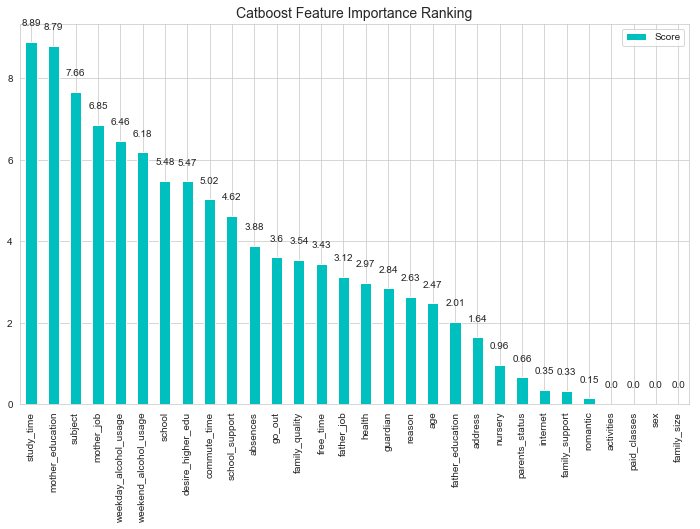

In [16]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

### Preprocessing

In [17]:
X_train = preprocessing_data(X_train)
X_test = preprocessing_data(X_test)
X_train = X_train[X_test.columns]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
columns = np.array(X_train.columns.values)

In [19]:
ros = RandomOverSampler(random_state=0)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [20]:
X_train = pd.DataFrame(X_train)
X_train.columns = columns

### Decision Tree

In [21]:
tree = DecisionTreeClassifier(max_depth=9, min_samples_leaf = 5)

In [22]:
from sklearn.model_selection import GridSearchCV, cross_val_score

tree_params = {'max_depth': [3,5,7,9],'min_samples_leaf': [3,5]}
tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params,cv=5, n_jobs=-1,verbose=True, scoring='roc_auc')
tree_grid.fit(X_train, y_train)
print(tree_grid.best_params_)
print(tree_grid.best_score_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'max_depth': 9, 'min_samples_leaf': 5}
0.7710121753409785


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    2.2s finished


In [23]:
train_predict_model(tree, X_train, y_train, X_test, y_test)

Accuracy: 0.675
[[ 67  53]
 [ 49 145]]
              precision    recall  f1-score   support

           0       0.58      0.56      0.57       120
           1       0.73      0.75      0.74       194

   micro avg       0.68      0.68      0.68       314
   macro avg       0.65      0.65      0.65       314
weighted avg       0.67      0.68      0.67       314

ROC-AUC: 0.66407


In [24]:
from sklearn.tree import export_graphviz

export_graphviz(tree, out_file="tree.dot", class_names=["pass", "fail"],feature_names=X_train.columns, impurity=False, filled=True)

In [25]:
import graphviz 
 
with open("tree.dot") as f:
    dot_graph = f.read()
    graphviz.Source(dot_graph) 

In [26]:
fi1 = pd.DataFrame({'feature': X_train.columns, 'importance': tree.feature_importances_}).sort_values(by='importance', ascending=False)

In [27]:
fi1

,feature,importance
11,desire_higher_edu,0.090108
46,subject__Math,0.074819
20,absences,0.065919
18,weekend_alcohol_usage,0.064894
22,school__MS,0.059884
6,school_support,0.059509
1,age,0.057737
17,weekday_alcohol_usage,0.050741
16,go_out,0.039390
29,mother_job__at_home,0.036143


### Random Forest

In [28]:
forest = RandomForestClassifier(n_estimators=500, min_samples_leaf= 3, max_depth=9)

In [29]:
tree_params = {'max_depth': [3,5,7,9],'min_samples_leaf': [3,5], 'n_estimators': [100, 200, 500]}
grid_search = GridSearchCV(RandomForestClassifier(), tree_params, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

print("Наилучшие значения параметров: {}".format(grid_search.best_params_))
print("Наилучшее значение кросс-валидац. правильности:{:.2f}".format(grid_search.best_score_))
accuracy_score(y_test, grid_search.predict(X_test))

Наилучшие значения параметров: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 500}
Наилучшее значение кросс-валидац. правильности:0.88


0.6878980891719745

In [30]:
train_predict_model(forest, X_train, y_train, X_test, y_test)

Accuracy: 0.697
[[ 63  57]
 [ 38 156]]
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       120
           1       0.73      0.80      0.77       194

   micro avg       0.70      0.70      0.70       314
   macro avg       0.68      0.66      0.67       314
weighted avg       0.69      0.70      0.69       314

ROC-AUC: 0.75503


In [31]:
fi = pd.DataFrame({'feature': X_train.columns, 'importance': forest.feature_importances_}).sort_values(by='importance', ascending=False)

In [32]:
fi

,feature,importance
20,absences,0.061146
2,mother_education,0.058009
18,weekend_alcohol_usage,0.050920
16,go_out,0.040380
11,desire_higher_edu,0.038737
17,weekday_alcohol_usage,0.038731
3,father_education,0.036905
1,age,0.036719
15,free_time,0.033488
5,study_time,0.031902
